In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pdp
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import json
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [34]:
# LOAD DATA
INPUT_DIR  = '../../../input/lv2'
LOG_NAME = '06_22_01_22_26'
predicted = np.load(f"../log/{LOG_NAME}/pred_valid.npy")
test = np.load(f"../log/{LOG_NAME}/pred_test.npy")
json_load = json.load(open(f'../log/{LOG_NAME}/params.json', 'r'))
state =  json_load['state']
data = pd.read_csv(INPUT_DIR+'/sales_lv2.csv')
data = data[data['index']==state]

In [35]:
# InverseするためのScalerを作る
data = data.drop(['d_1062','d_1427','d_1792'],axis=1)
use_days = json_load['use_days']
train_x = np.array(data.iloc[:, -1 * (28 + use_days) : -28*2]).sum(axis=0).reshape(1,-1)
# train_x = np.array(data.iloc[:, -1 * (28*1 + use_days) : -28*1]).sum(axis=0).reshape(1,-1)
mm = MinMaxScaler(feature_range=(0.05, 0.95))
mm.fit(train_x.T)

MinMaxScaler(copy=True, feature_range=(0.05, 0.95))

In [36]:
# 予測値をInverse Transform
predicted = mm.inverse_transform(predicted)
test = mm.inverse_transform(test)

In [37]:
days = 100
sells = np.array(data.iloc[:, -1 * days : -28]).sum(axis=0)
sells.reshape(1,-1).shape

(1, 72)

In [38]:
y_true = data.iloc[:,-28:].sum(axis=0).values.reshape(1,-1)
from sklearn.metrics import mean_squared_error
print('RMSE:',np.sqrt(mean_squared_error(y_true, predicted)))
RMSE = np.sqrt(mean_squared_error(y_true, predicted))

RMSE: 1308.6841741454837


In [39]:
predicted.shape

(1, 28)

lv2_state: TX
RMSE: 1308.6841741454837


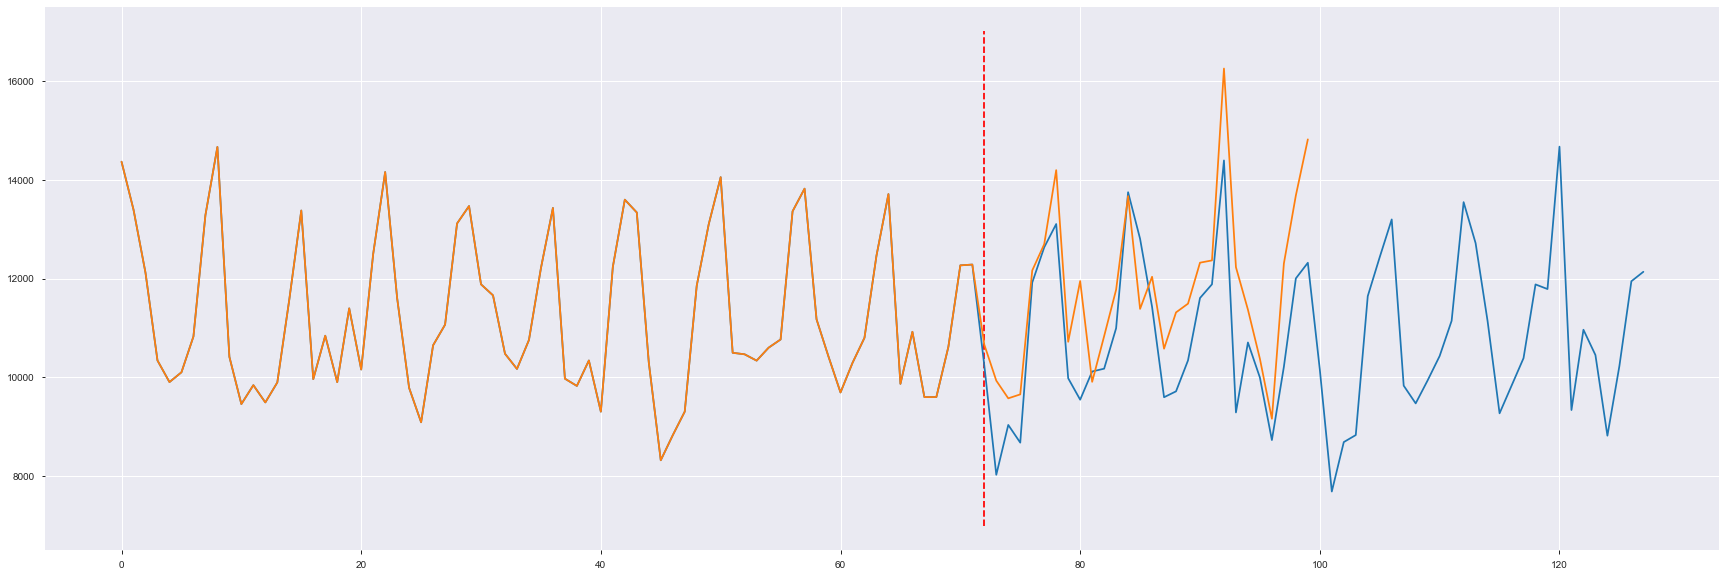

In [49]:
days = 100
f, ax = plt.subplots(figsize=(30, 10))
sells = np.array(data.iloc[:, -1 * days : -28]).sum(axis=0)
plt.plot(np.concatenate([sells.reshape(1,-1),predicted,test],axis=1).reshape(-1,))
plt.plot(np.array(data.iloc[:, -1 * days :]).sum(axis=0))
# sns.lineplot(predicted.iloc[i, :].index, predicted.iloc[i,:].values.astype("float32"))
if state == 'WI':
    plt.vlines(days-28, 8000, 20000, "red", linestyles='dashed')
if state == 'CA':
    plt.vlines(days-28, 10000, 30000, "red", linestyles='dashed')
if state == 'TX':
    plt.vlines(days-28, 7000, 17000, "red", linestyles='dashed')
plt.savefig(f"../log/{LOG_NAME}/pred_{RMSE}.png")
print('lv2_state:',state)
print('RMSE:',RMSE)